# Generate MNIST digits using GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from keras import layers as L
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Some constants
img_height = 64
img_width = 64
img_channels = 3
img_shape = (img_height, img_width, img_channels)
latent_dim = 250
batch_size = 64
n_epochs = 2000
img_path = r"C:\__MyComputer\OneDrive - Teradata\Drive_SM\Course\analyticsvidhya\facecounting\image_data"
img_path = r"/home/dell/sm186047/facecounting/image_data"

In [3]:
# save the generated images
def sample_images(generator, epoch):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images
    gen_imgs = ((gen_imgs+1)*127.5).astype(np.uint8)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    # fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

In [4]:
# Loss functions
from keras.applications.vgg16 import VGG16


def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [5]:
# define the generator
def build_generator():

    model = Sequential()

    model.add(L.Dense(256, input_dim=latent_dim))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Dense(256))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Dense(512))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Dense(512))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Dense(1024))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Dense(1024))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.BatchNormalization(momentum=0.8))
    # this layer will generate the image. it must have as many units as many pixels are there in the output image.
    model.add(L.Dense(np.prod(img_shape), activation='tanh'))
    # reshape as an image
    model.add(L.Reshape(img_shape))
    model.name = 'G'
    model.summary()

    noise = L.Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [10]:
# define the discriminator
def build_discriminator():

    model = Sequential()
    
    model.add(L.Conv2D(filters=196, kernel_size=(3, 3), strides=2, padding='same', input_shape=img_shape))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Conv2D(filters=196, kernel_size=(3, 3), strides=2, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Conv2D(filters=196, kernel_size=(3, 3), strides=2, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.LeakyReLU(0.2))
    model.add(L.Flatten())
    model.add(L.Dense(512))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.Dense(256))
    model.add(L.advanced_activations.LeakyReLU(alpha=0.2))
    model.add(L.Dense(1, activation='sigmoid'))
    model.name = 'D'
    model.summary()

    img = L.Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [7]:
def generator_containing_discriminator(generator, discriminator):
    inputs = L.Input(shape=(latent_dim,))
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs, name='DonG')
    model.summary()
    return model


def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = L.Input(shape=(latent_dim,))
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs], name='DonGM')
    model.summary()
    return model

In [8]:
def train_multiple_outputs(log_dir=r'log', epoch_num=n_epochs, critic_updates=2):
    print("Image path", img_path)
    datagen = ImageDataGenerator( 
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.2
        ).flow_from_directory(
                img_path,
                # '../input/all-dogs/',
                target_size=(img_height, img_width),
                batch_size=64)
    imgs, _ = next(datagen)
    print(imgs.shape)
    from keras.preprocessing import image
    plt.imshow(image.array_to_img(imgs[3]))
    plt.show()

    g = build_generator()
    d = build_discriminator()
    
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True


    for epoch in tqdm_notebook(range(epoch_num)):
        d_losses = []
        d_on_g_losses = []
        for idx in tqdm_notebook(range(len(datagen)), total=len(datagen)):
            batch_size = len(datagen[idx][0])
            # Adversarial ground truths
            output_true_batch = np.ones((batch_size, 1))
            output_false_batch = np.zeros((batch_size, 1))
            
            # Select a batch of images
            imgs = datagen[idx][0]
            real_imgs = (imgs - 127.5) / 127.5

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            generated_images = g.predict(x=noise, batch_size=batch_size)

            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(real_imgs, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            d.trainable = False

            d_on_g_loss = d_on_g.train_on_batch(noise, [real_imgs, output_true_batch])
            d_on_g_losses.append(d_on_g_loss)

            d.trainable = True

        # write_log(tensorboard_callback, ['g_loss', 'd_on_g_loss'], [np.mean(d_losses), np.mean(d_on_g_losses)], epoch_num)
        print(epoch, np.mean(d_losses), np.mean(d_on_g_losses))
        # If at save interval => save generated image samples
        if epoch % 10 == 0:
            sample_images(g, epoch)
            # save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))


Image path /home/dell/sm186047/facecounting/image_data
Found 10476 images belonging to 1 classes.
(64, 64, 64, 3)


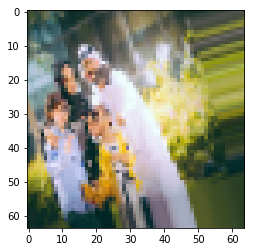

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               64256     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
__________

0 0.0006418615009639989 4725.489


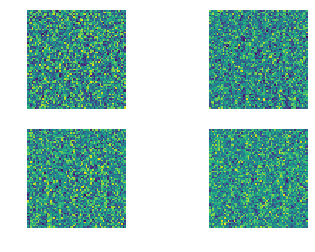

1 7.347596112413925e-12 4497.174


2 8.50604990605089e-12 4296.5396


3 7.719299762790274e-12 4177.9756


4 7.948342716886395e-12 4118.1694


5 8.442775392430362e-12 4094.6743


6 7.68738493245682e-12 4083.8828


7 7.761813055110972e-12 4072.3306


8 8.409814848605722e-12 4060.4126


9 7.925641012850338e-12 4054.4233


10 7.44302010697166e-12 4050.905


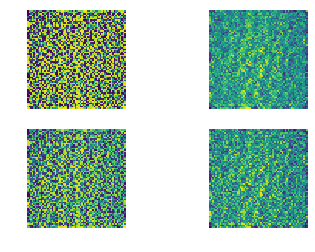

11 7.539222381514736e-12 4046.341


12 7.839350954859982e-12 4039.5212


13 8.43829584703694e-12 4037.378


14 8.158493507625856e-12 4035.9375


15 7.666540529546626e-12 4029.5947


16 7.81429602339404e-12 4027.9985


17 7.77797591832565e-12 4026.539


In [ ]:
train_multiple_outputs()

## The End